# Submission 02 -- Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score

In [2]:
df = pd.read_csv('../datasets/data_fillna.csv')

df.dtypes

Id                int64
PID               int64
MS SubClass       int64
MS Zoning        object
Lot Frontage    float64
                 ...   
Misc Val          int64
Mo Sold           int64
Yr Sold           int64
Sale Type        object
SalePrice         int64
Length: 81, dtype: object

In [3]:
df.select_dtypes(include='object').columns

Index(['MS Zoning', 'Street', 'Alley', 'Lot Shape', 'Land Contour',
       'Utilities', 'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Roof Style', 'Roof Matl',
       'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Foundation',
       'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating',
       'Central Air', 'Electrical', 'Functional', 'Garage Type',
       'Garage Finish', 'Garage Cars', 'Garage Area', 'Paved Drive', 'Fence',
       'Misc Feature', 'Sale Type'],
      dtype='object')

In [4]:
plt.figure(figsize=(7,200))
corr = pd.get_dummies(df,columns=df.select_dtypes(include='object').columns).corr()

<Figure size 504x14400 with 0 Axes>

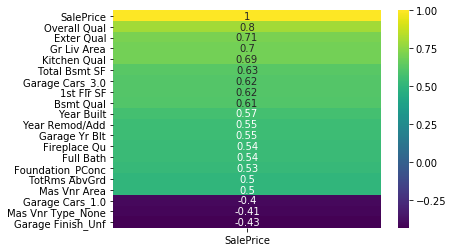

In [5]:
sns.heatmap(corr.loc[~corr['SalePrice'].between(-0.4,0.5),['SalePrice']].sort_values(by='SalePrice',ascending=False)
            ,cmap='viridis'
            ,annot=True
           )

In [6]:
features = corr.loc[~corr['SalePrice'].between(-0.4,0.5),['SalePrice']].index.values
features

array(['Overall Qual', 'Year Built', 'Year Remod/Add', 'Mas Vnr Area',
       'Exter Qual', 'Bsmt Qual', 'Total Bsmt SF', '1st Flr SF',
       'Gr Liv Area', 'Full Bath', 'Kitchen Qual', 'TotRms AbvGrd',
       'Fireplace Qu', 'Garage Yr Blt', 'SalePrice', 'Mas Vnr Type_None',
       'Foundation_PConc', 'Garage Finish_Unf', 'Garage Cars_1.0',
       'Garage Cars_3.0'], dtype=object)

## Second Attempt:
After dummying every column, we are going to take anything NOT between -0.40 and 0.5 in correlation.
We will create a function that will build us an X and y variable that will format our train data and our test data.

In [7]:
def fix_data_get_X_y(csv,features,model=None,test=False):
    df = pd.read_csv(csv)
    
    adj_df = pd.get_dummies(df,columns=df.select_dtypes(include='object').columns)
    for col in features:
        if col in adj_df.columns:
            pass
        else:
            adj_df[col] = 0
            
    X = adj_df[features].drop(columns='SalePrice')
    
    if test:
        y = model.predict(X)
    else:
        y = df['SalePrice']
    return adj_df, X, y

In [12]:
train, X, y = fix_data_get_X_y('../datasets/data_fillna.csv',features)
X.head(), y.head()

(   Overall Qual  Year Built  Year Remod/Add  Mas Vnr Area  Exter Qual  \
 0             6        1976            2005         289.0           4   
 1             7        1996            1997         132.0           4   
 2             5        1953            2007           0.0           3   
 3             5        2006            2007           0.0           3   
 4             6        1900            1993           0.0           3   
 
    Bsmt Qual  Total Bsmt SF  1st Flr SF  Gr Liv Area  Full Bath  Kitchen Qual  \
 0          3          725.0         725         1479          2             4   
 1          4          913.0         913         2122          2             4   
 2          3         1057.0        1057         1057          1             4   
 3          4          384.0         744         1444          2             3   
 4          2          676.0         831         1445          2             3   
 
    TotRms AbvGrd  Fireplace Qu  Garage Yr Blt  Mas Vnr Type

In [13]:
lr = LinearRegression()

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [15]:
cross_val_score(lr, X_train, y_train, cv=5).mean()

0.8158762227133016

In [16]:
lr.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [17]:
lr.score(X_train,y_train)

0.8402090771663182

In [18]:
lr.score(X_test,y_test)

0.8007745324202307

In [19]:
def create_submission(model=lr,feat=features,test_name='sub_02'):
    
    df, X_test, y_test = fix_data_get_X_y('./datasets/test_fillna.csv',feat,model=model,test=True)
    print(X_test.columns)
    df['SalePrice'] = y_test
    submission = df[['Id','SalePrice']]
    
    submission.to_csv(f'./datasets/{test_name}.csv',index=False)
    return submission.shape

In [20]:
create_submission(lr,features,'sub_02')

FileNotFoundError: [Errno 2] File b'./datasets/test_fillna.csv' does not exist: b'./datasets/test_fillna.csv'

In [33]:
df[['Overall Qual', 'Exter Qual','Gr Liv Area', 'Kitchen Qual','Bsmt Qual']].dtypes

Overall Qual    int64
Exter Qual      int64
Gr Liv Area     int64
Kitchen Qual    int64
Bsmt Qual       int64
dtype: object

[[ 1.  6.  4. ... 48. 36. 27.]
 [ 1.  7.  4. ... 64. 64. 64.]
 [ 1.  5.  3. ... 48. 36. 27.]
 ...
 [ 1.  6.  3. ... 27. 27. 27.]
 [ 1.  4.  3. ... 27. 27. 27.]
 [ 1.  7.  3. ... 48. 36. 27.]]


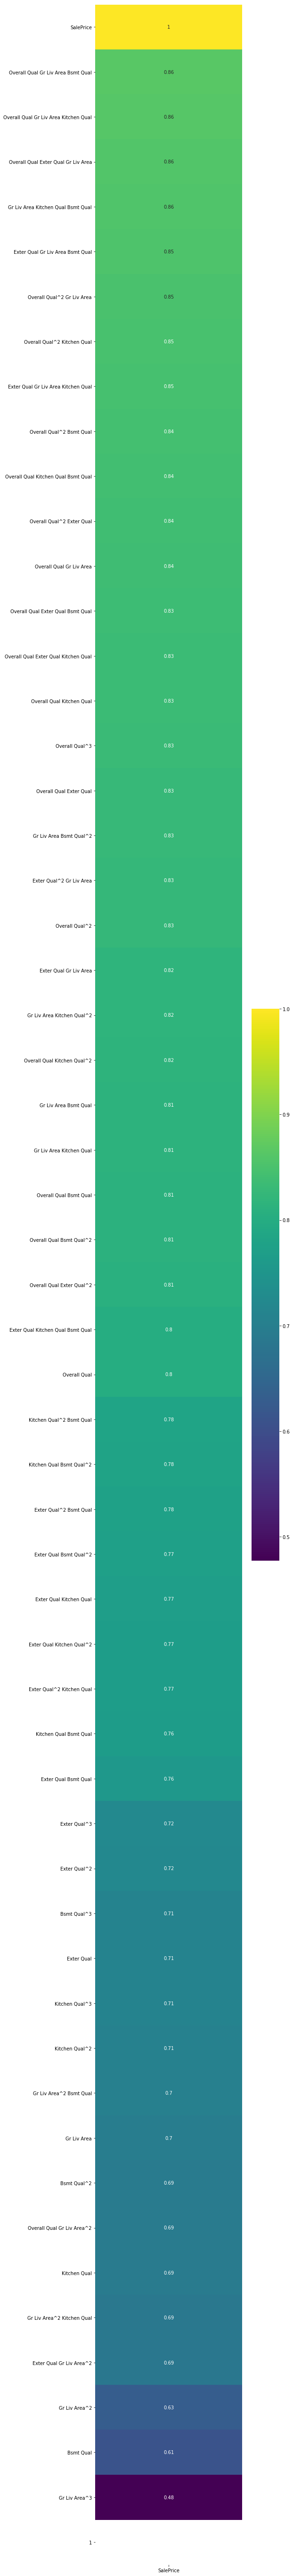

In [35]:
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer
poly = PolynomialFeatures(degree=3)

df.select_dtypes(include='number').columns

features = ['Overall Qual', 'Exter Qual', 'Gr Liv Area', 'Kitchen Qual','Bsmt Qual']
X_train = poly.fit_transform(df[features])

print(X_train)

data = pd.DataFrame(X_train,columns=poly.get_feature_names(features))

data['SalePrice'] = df['SalePrice']

plt.figure(figsize=(7,100))
sns.heatmap(data.corr()[['SalePrice']].sort_values(by='SalePrice',ascending=False)
            ,annot=True
            ,cmap='viridis')



In [27]:
X_train

array([[1.00000000e+00, 6.00000000e+00, 4.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 7.07788800e+06],
       [1.00000000e+00, 7.00000000e+00, 4.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 2.10245760e+07],
       [1.00000000e+00, 5.00000000e+00, 3.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 3.46459760e+07],
       ...,
       [1.00000000e+00, 6.00000000e+00, 3.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 7.19323136e+08],
       [1.00000000e+00, 4.00000000e+00, 3.00000000e+00, ...,
        1.65937500e+08, 6.52687500e+07, 2.56723750e+07],
       [1.00000000e+00, 7.00000000e+00, 3.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 9.82107784e+08]])

In [22]:
X_train.shape

(2051, 165)

In [24]:
df['Exter Qual'].value_counts()

3    1247
4     697
5      81
2      26
Name: Exter Qual, dtype: int64